In [213]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from autoencoder import CustomDataset, Autoencoder, Autoencoder_no_lineal
from collections import defaultdict

In [214]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

train_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set_orig = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

train_set_autoencoder = CustomDataset(train_set_orig)
valid_set_autoencoder = CustomDataset(valid_set_orig)

In [215]:
train_set_autoencoder = CustomDataset(train_set_orig)
valid_set_autoencoder = CustomDataset(valid_set_orig)

In [216]:
train_loader = DataLoader(train_set_autoencoder, batch_size=100, shuffle=True, num_workers=os.cpu_count()-1)
valid_loader = DataLoader(valid_set_autoencoder, batch_size=100, shuffle=False, num_workers=os.cpu_count()-1)

In [217]:
import json
files = os.listdir('./results')
files = [f for f in files if f.endswith('.json')]
files.sort()
# Initialize the dictionary to store the models
models_dict = {}
for i, (data) in enumerate(files):
    with open(f'./results/{data}', 'r') as f:
        data = json.load(f)
        keys = list(data.keys())
        config = data[keys[0]]
        id = config['id']

        dropout = config['dropout']
        l_size = config['l_size']
        lineal = config['lineal']

        if lineal:
            model = Autoencoder(dropout, l_size)
        else:
            model = Autoencoder_no_lineal(dropout)

        model.load_state_dict(torch.load(f'./results/model_{id}.pt', weights_only=True, map_location=torch.device('cpu')))
        model.eval()
        models_dict[id] = model
print(models_dict)

RuntimeError: Error(s) in loading state_dict for Autoencoder_no_lineal:
	Missing key(s) in state_dict: "encoder.3.weight", "encoder.3.bias", "decoder.2.weight", "decoder.2.bias". 
	Unexpected key(s) in state_dict: "encoder.4.weight", "encoder.4.bias", "decoder.3.weight", "decoder.3.bias". 
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([32, 1, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 1, 3, 3]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([64, 32, 2, 2]) from checkpoint, the shape in current model is torch.Size([32, 16, 2, 2]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).

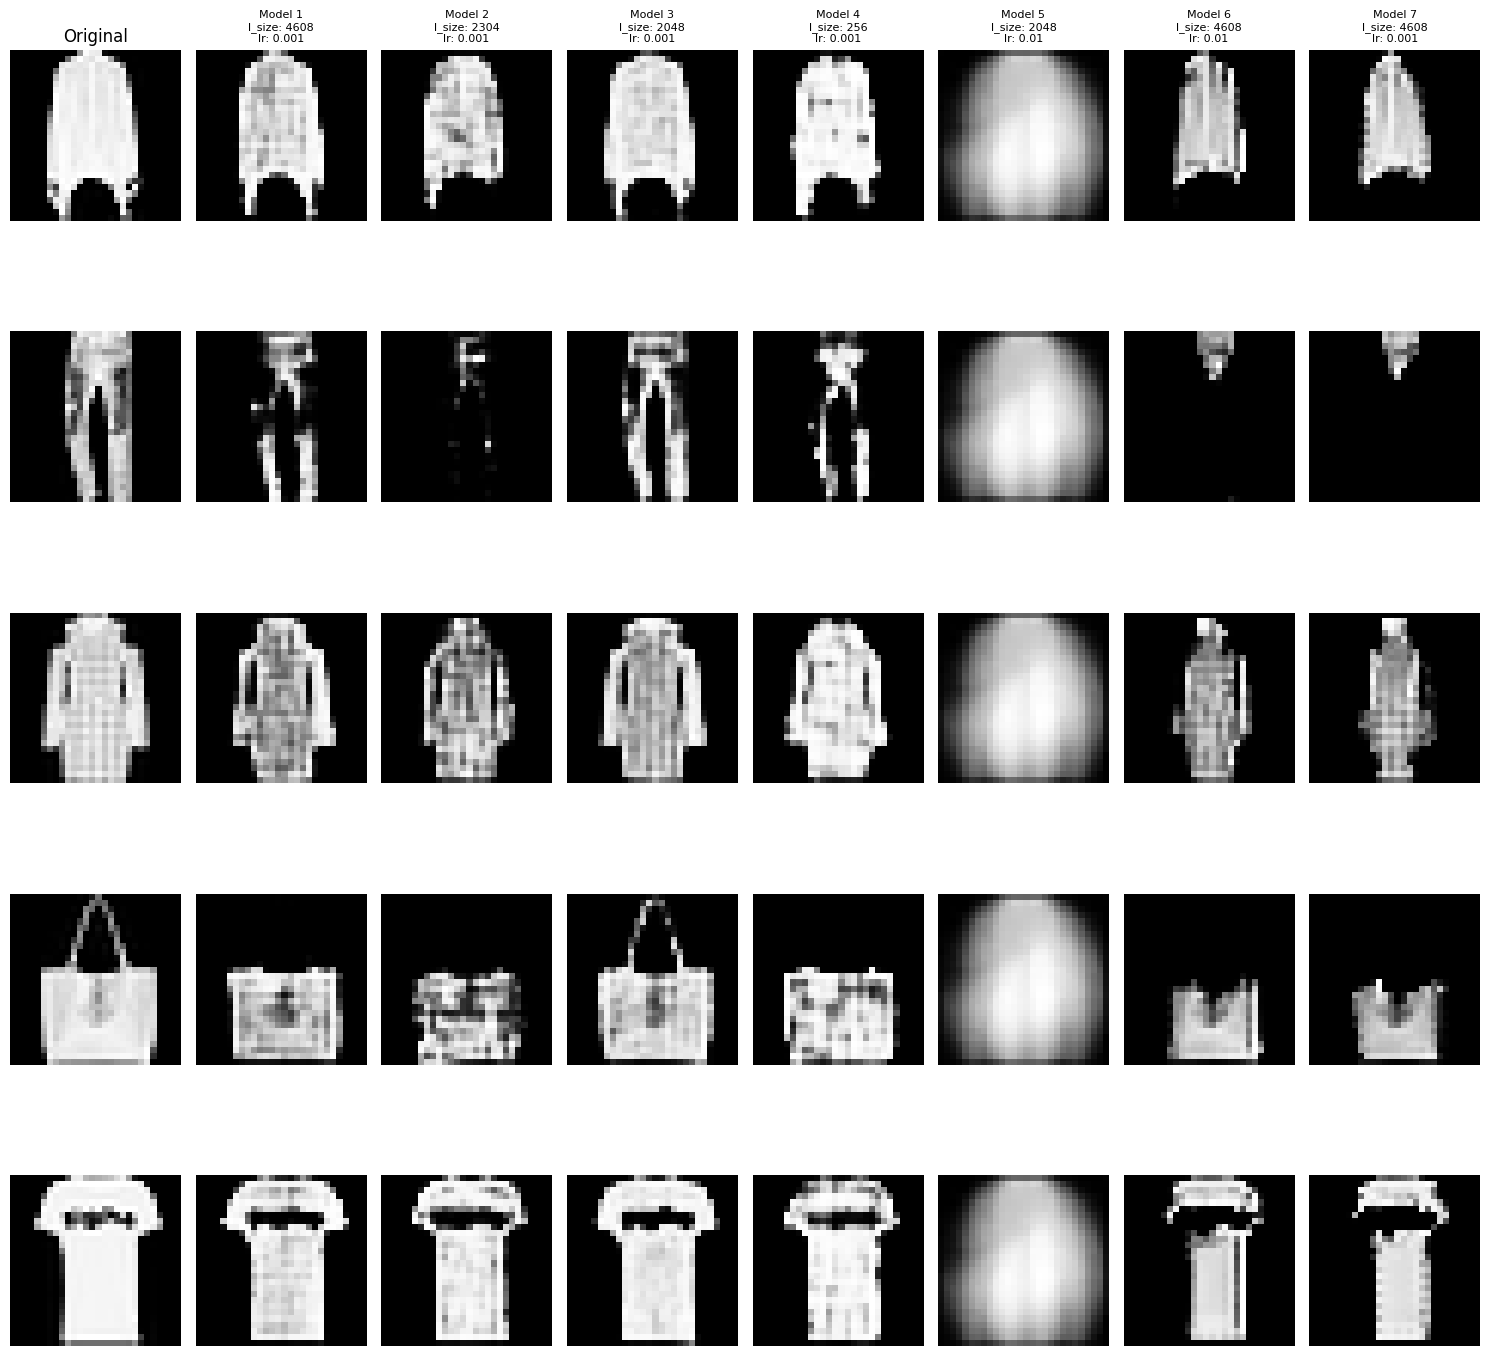

In [ ]:
fig, axs = plt.subplots(5, 8, figsize=(15, 15))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for idx in range(5):
    j = torch.randint(len(valid_set_autoencoder), size=(1,)).item()
    image, _ = valid_set_autoencoder[j]
    image = image.unsqueeze(0).to(device)
    
    axs[idx, 0].imshow(image.squeeze().cpu(), cmap="Greys_r")
    axs[idx, 0].axis("off")
    if idx == 0:
        axs[idx, 0].set_title("Original")
    
    for model_idx in range(1, 8):
        model = models_dict[model_idx]
        model.to(device)
        with torch.no_grad():
            model.eval()
            output = model(image)
        
        axs[idx, model_idx].imshow(output.squeeze().cpu(), cmap="Greys_r")
        axs[idx, model_idx].axis("off")
        if idx == 0:
            config = json.load(open(f'./results/result_{model_idx}.json'))[f'config_{model_idx}']
            l_size = config['l_size']
            learning_rate = config['learning_rate']
            axs[idx, model_idx].set_title(f"Model {model_idx}\nl_size: {l_size}\nlr: {learning_rate}", fontsize=8)

plt.tight_layout()
plt.show()

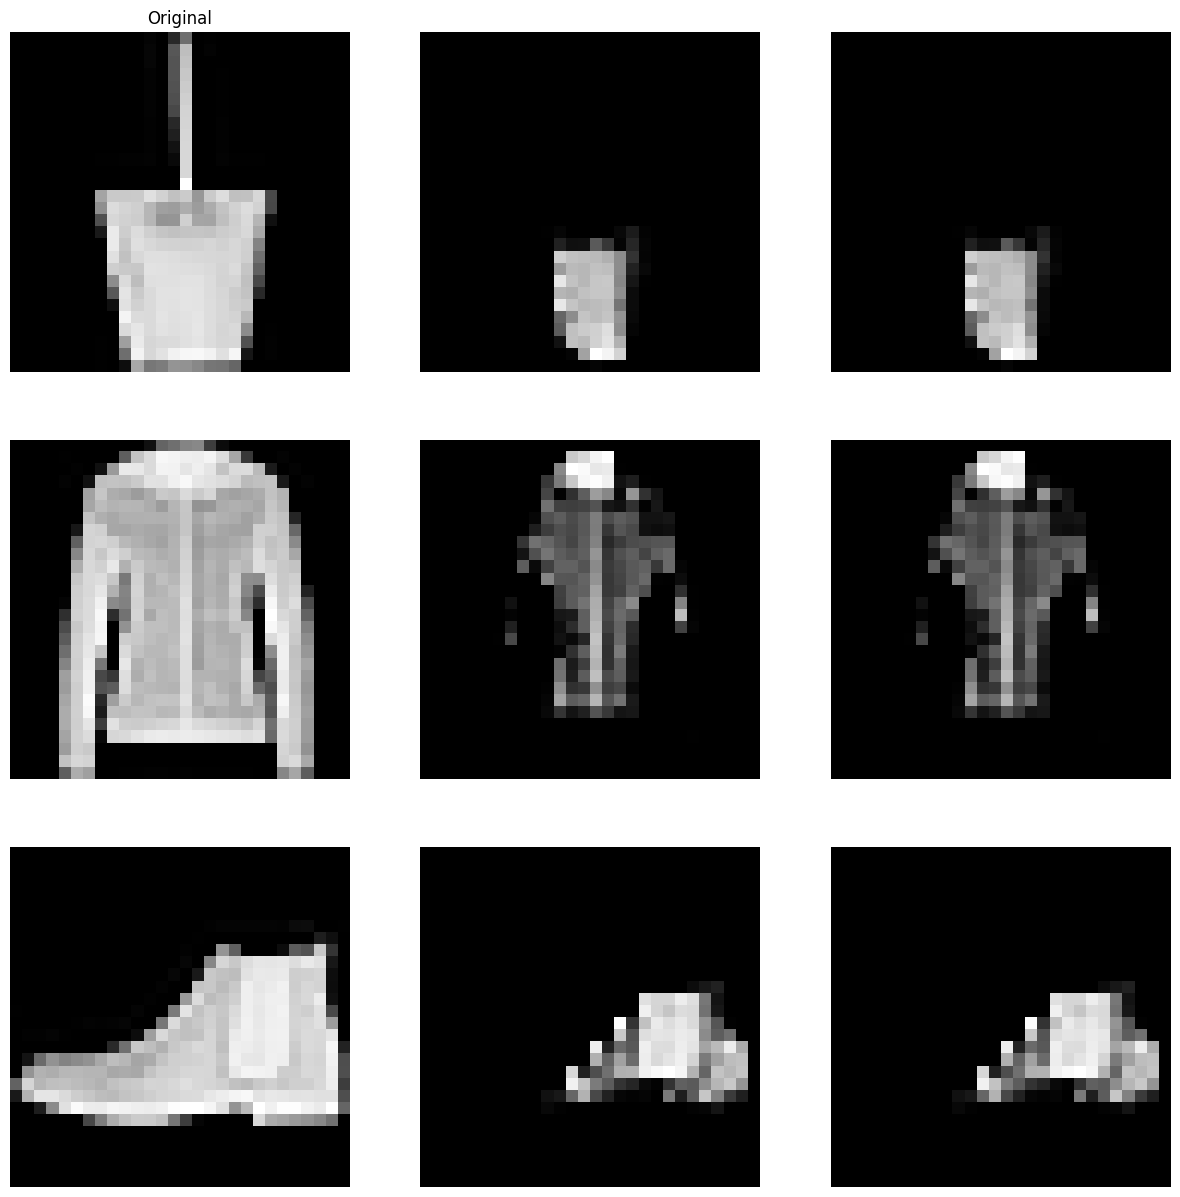

In [ ]:
model2 = models_dict[7]
model2.to(device)
model2.eval()

fig,axs = plt.subplots(3,3,figsize=(15,15))

for i in range(3):
    j = torch.randint(len(train_set_autoencoder), size=(1,)).item()
    image, _ = train_set_autoencoder[j]
    image = image.unsqueeze(0).to(device)
    axs[i,0].imshow(image.squeeze().cpu(), cmap="Greys_r")
    axs[i,0].axis("off")
    if i == 0:
        axs[i,0].set_title("Original")
    with torch.no_grad():
        model2.eval()
        output = model2(image)
    axs[i,1].imshow(output.squeeze().cpu(), cmap="Greys_r")
    axs[i,1].axis("off")
    with torch.no_grad():
        model2.eval()
        output = model2(image)
    axs[i,2].imshow(output.squeeze().cpu(), cmap="Greys_r")
    axs[i,2].axis("off")